## DNN 二分类模型

这里需要使用神经网络模型来了实现一个二分类模型，主要的分类的数据是一个圆环数据的分类。

### 数据准备

**tf.concat**

>拼接张量的函数,其实这和numpy中的np.concatenate()用法是一样的。
axis=0     代表在第0个维度拼接
axis=1     代表在第1个维度拼接 
tf.concat([tensor1, tensor2, tensor3,...], axis)


```python
  t1 = [[1, 2, 3], [4, 5, 6]]
  t2 = [[7, 8, 9], [10, 11, 12]]
  tf.concat([t1, t2], 0)  # [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
  tf.concat([t1, t2], 1)  # [[1, 2, 3, 7, 8, 9], [4, 5, 6, 10, 11, 12]]
 
  # tensor t3 with shape [2, 3]
  # tensor t4 with shape [2, 3]
  tf.shape(tf.concat([t3, t4], 0))  # [4, 3]
  tf.shape(tf.concat([t3, t4], 1))  # [2, 6]




In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本，小圆环分布
# 圆的半径+随机值
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
# 圆的角度
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi)
# 计算圆点的位置，利用tf.concat实现数据的拼接
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis=1)
# 标签为1，正样本标签的数据
Yp = tf.ones_like(r_p)

#生成负样本，小圆环分布
# 圆的半径+随机值
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
# 圆的角度
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi)
# 计算圆点的位置，tf.concat将数据在列维度上拼接
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis=1)
# 标签为0，负样本标签的数据
Yn = tf.zeros_like(r_n)

# 汇总数据
X = tf.concat([Xp,Xn],axis=0)
Y = tf.concat([Yp,Yn],axis=0)


In [11]:
#打印时间分割线
@tf.function
def printbar():
    ts = tf.timestamp()

    # 计算当天时间的秒数，记录的时间的开文天文台的时间
    today_ts = ts%(24*60*60)

    # 计算当前的日期时：需要+8表示当前北京时间
    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    # 计算分钟
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    # 计算秒钟
    second = tf.cast(tf.floor(today_ts%60),tf.int32)

    # 是否需要在前面加0
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))

    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*5,end = "")
    tf.print(timestring)

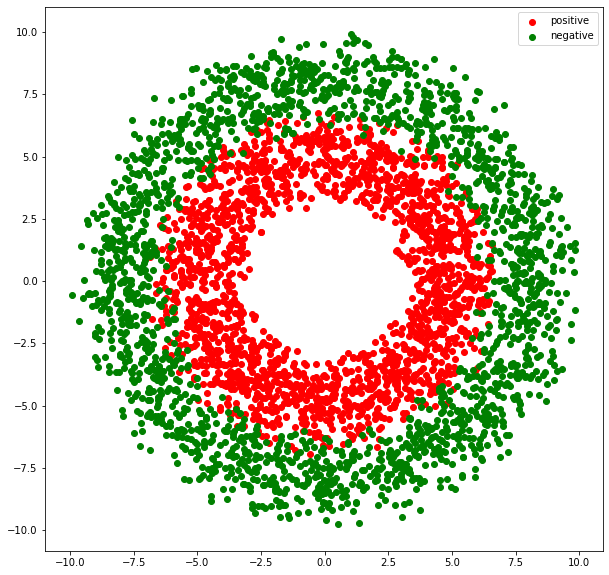

In [10]:
#可视化
plt.figure(figsize = (10,10))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"])

In [2]:
# 构建管道数据
# 其实就是做好mini_batch 数据的生成，作为单步训练样本
def data_iter(features,lable,batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        indexs = indices[i:min(i+batch_size,num_examples)]
        yield tf.gather(X,indexs),tf.gather(Y,indexs)



In [12]:
# 测试管道数据

batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
tf.print(features)
tf.print(labels)

[[5.18664 1.20586681]
 [7.25909 -6.18234253]
 [-3.15677214 -5.53220129]
 ...
 [-0.527540445 -5.00089025]
 [-6.14221191 0.939712465]
 [-7.95283 -1.7125839]]
[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


### 构建模型

这里使用tf.Module作为基类来创建
- 定义的模型必须继承于tf.Module这个父类
- 使用父类的构造函数
    - super(DNNModel,self).__init__(name=name)
- 构造函数中定义变量参数
- 在call函数中完成正向传播

In [7]:
class DNNModel(tf.Module):
    def __init__(self,name=None):
        # 这里不知道为什么，需要仔细研究
        super(DNNModel,self).__init__(name=name)
        # 第一层：4个神经元
        self.w1 = tf.Variable(tf.random.truncated_normal([2,4]),dtype=tf.float32)
        self.b1 = tf.Variable(tf.zeros([1,4]),dtype=tf.float32)
        # 第一层：8个神经元
        self.w2 = tf.Variable(tf.random.truncated_normal([4,8]),dtype=tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,8]),dtype=tf.float32)
        # 第三层：1个神经元，作为最后的结果输出
        self.w3 = tf.Variable(tf.random.truncated_normal([8,1]),dtype=tf.float32)
        self.b3 = tf.Variable(tf.zeros([1,1]),dtype=tf.float32)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None,2],dtype=tf.float32)])
    def __call__(self,x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3+self.b3)
        return y

    # 利用交叉熵计算损失值
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,1],dtype=tf.float32),tf.TensorSpec(shape=[None,1],dtype=tf.float32)])
    def loss_func(self,y_true,y_pred):
        eps = 1e-7
        #将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免log(0)错误
        y_pred = tf.clip_by_value(y_pred,eps,1.0-eps)
        bce = -y_true*tf.math.log(y_pred)-(1-y_true)*tf.math.log(1-y_pred)
        return tf.reduce_mean(bce)

    # 评估准确率
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,1],dtype=tf.float32),tf.TensorSpec(shape=[None,1],dtype=tf.float32)])
    def metric_func(self,y_true,y_pred):
        y_pred = tf.where(y_pred>0.5,tf.ones_like(y_pred,dtype = tf.float32),tf.zeros_like(y_pred,dtype = tf.float32))
        acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
        return acc


model = DNNModel()

In [8]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
print(features.shape)

predictions = model(features)

loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

tf.print("init loss:",loss)
tf.print("init metric",metric)

(10, 2)
init loss: 6.28819418
init metric 0.3


In [9]:
print(len(model.trainable_variables))

6


### 训练模型



In [10]:
@tf.function
def train_step(model,features,labels):

    #使用自动微分来求损失值
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels,predictions)

    # 反向传播计算梯度值
    grads = tape.gradient(loss,model.trainable_variables)

    # 参数更新
    #使用zip打包成一个元组列表，方便用for来遍历
    for p,dloos_dp in zip(model.trainable_variables,grads):
        p.assign(p-0.001*dloos_dp)

    # 模型评估
    metric = model.metric_func(labels,predictions)

    return loss,metric

In [14]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features,labels in data_iter(X,Y,100):
            loss,metric = train_step(model,features,labels)

        if epoch%100 == 0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ", metric)
        

In [15]:
train_model(model,epochs = 600)

==================================================08:49:41
epoch = 100 loss =  0.518825769 accuracy =  0.83
==================================================08:49:59
epoch = 200 loss =  0.378967673 accuracy =  0.92
==================================================08:50:17
epoch = 300 loss =  0.333447963 accuracy =  0.89
==================================================08:50:34
epoch = 400 loss =  0.223346382 accuracy =  0.94
==================================================08:50:51
epoch = 500 loss =  0.239406735 accuracy =  0.93
==================================================08:51:06
epoch = 600 loss =  0.1640995 accuracy =  0.98


Text(0.5, 1.0, 'y_pred')

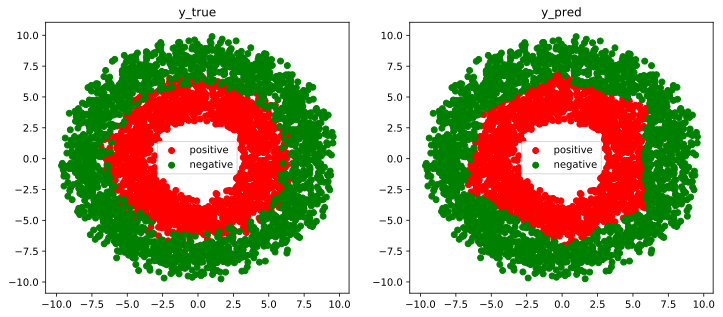

In [16]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1],c = "r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"])
ax1.set_title("y_true")

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"])
ax2.set_title("y_pred")